## Домашнее задание: "Детекция объектов на изображении"

ФИО: Колодяжный Даниил Антонович

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество).
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)
    3. Вы можете использовать RetinaNet, которая была реализована на семинаре, но это приведет к снижению оценки на **–2.5 балла**, так как задания 1.1 и 2.1 уже были выполнены в рамках занятия.

1. Подготовка обучающего набора данных
    0. Для выполнения задания используйте датасет с изображениями мячей, который использовался на семинаре.
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

### 0. Выбор модели и подготовка данных

#### Загрузка данных

In [1]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=4e69bcb1-2629-4b1c-8297-811950119fff
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:06<00:00, 170MB/s]


In [2]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd

#### Выбор модели

Была выбрана модель Faster R-CNN, т.к. модель хорошо зарекомендовала себя в задачах детекции объектов, и есть множество ресурсов предобученных весов для нее. Реализация Faster R-CNN будет взята из библиотеки torchvision.

In [3]:
import torch
from torchvision import models

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: cuda


Выбираем преобученную модель:
- тип модели: Faster R-CNN;
- тип сверточной сети: ResNet50 – 50 слое с обходящими связями;
- доп. механизм: FPN – пирамида активаций – скомбинировав карты с разных слоев основной сети (`backbone`), получить карты одновременно "семантически богатые" и с большим рецептивным полем.

In [5]:
model = models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 28.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### 1. Подготовка обучающего набора данных

#### Подготовка обучающего набора данных (реализация классов Dataset и Dataloader)

In [6]:
from torch.utils.data import Dataset
from torchvision.transforms import functional
from PIL import Image
import os

from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import json
import numpy
import random

Определим класс для работы с DataSet

In [7]:
class LearnData(Dataset):
    def __init__(self, img_dir, bounding_boxes, transforms=None):
        self.img_dir = img_dir
        self.bounding_boxes = bounding_boxes
        self.transforms = transforms

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, index):

        img_key = list(self.bounding_boxes.keys())[index] # ключ = имя файла изображения

        img_name = img_key
        bboxes = self.bounding_boxes[img_key] # аннотация

        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        # Преобразование bounding box в формат [x_min, y_min, x_max, y_max]
        corrected_bboxes = []
        for bbox in bboxes:
            x_min, x_max, y_min, y_max = bbox
            corrected_bboxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.tensor(corrected_bboxes, dtype=torch.float32)


        labels = torch.ones(len(bboxes), dtype=torch.int64)  # Список меток

        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            image, target = self.transforms(image, target)

        image = transforms.ToTensor()(image)

        return image, target

#### Аугментации

In [8]:
class TransformWithBBox:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image = transform(image)
            if isinstance(transform, RandomAffineWithBBox):
                image, target = transform(image, target)
        return image, target

In [9]:
simple_transforms = TransformWithBBox([
    transforms.Resize((1024, 1024)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
    transforms.ToTensor(),
])

In [10]:
# Зашумляем тензор
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean # независимый шум
        x = tensor + noise # добавили шум к изображению
        return torch.clamp(x, 0.0, 1.0) # возвращаем диапазон

noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(),
])

Сложные агументации, требующие пересчета bounding boxes.
Для корректной обработки посмотрим на структуру данных в JSON-файле bounding box

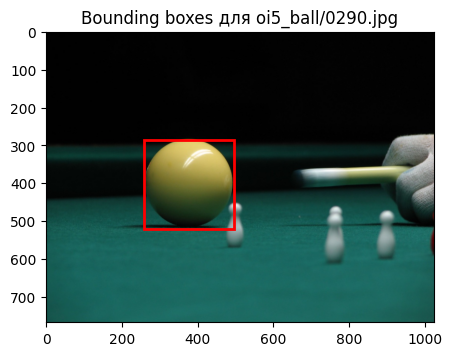

In [11]:
image_dir = "./seminar_objdet_retina_oi5_ball/"
json_file = "./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json"

with open(json_file, 'r') as file:
    file_data = json.load(file)

# Проверим, как выглядят аннотации для одного изображения
sample_image = list(file_data.keys())[31]
bboxes = file_data[sample_image]

img_path = os.path.join(image_dir, sample_image)
image = Image.open(img_path)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)

for bbox in bboxes:
    x_min, x_max, y_min, y_max = bbox

    rect = plt.Rectangle((x_min * image.width, y_min * image.height),
                         (x_max - x_min) * image.width,
                         (y_max - y_min) * image.height,
                         linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title(f"Bounding boxes для {sample_image}")
plt.show()

Нужно применять афинное преобразование к bounding box – преобразовать координаты [x_min, y_min, x_max, y_max] с учетом угла, сдвига и масштаба.

In [12]:
class RandomAffineWithBBox:
    def __init__(self, degrees=0, translate=None, scale=None, shear=None):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale if isinstance(scale, float) else 1.0
        self.shear = shear

    def __call__(self, image, target):

        angle = random.uniform(-self.degrees, self.degrees)
        translate = self.translate if self.translate is not None else (0, 0)
        scale = self.scale
        shear = self.shear if self.shear is not None else (0, 0)

        image = functional.affine(image, angle=angle, translate=translate, scale=scale, shear=shear, fill=0)

        boxes = target['boxes']
        target['boxes'] = boxes

        return image, target


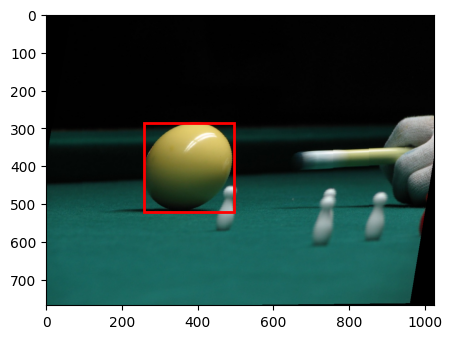

In [54]:
image_dir = "./seminar_objdet_retina_oi5_ball/"
json_file = "./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json"

with open(json_file, 'r') as file:
    file_data = json.load(file)

sample_image = list(file_data.keys())[31]
bboxes = file_data[sample_image]

img_path = os.path.join(image_dir, sample_image)
image = Image.open(img_path)

affine_transform = RandomAffineWithBBox(degrees=15, translate=(0.1, 0.1), scale=1.0, shear=10)
image, target = affine_transform(image, {'boxes': torch.tensor(bboxes)})

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)

for bbox in target['boxes']:
    x_min, x_max, y_min, y_max = bbox.numpy()
    rect = plt.Rectangle((x_min * image.width, y_min * image.height),
                         (x_max - x_min) * image.width,
                         (y_max - y_min) * image.height,
                         linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

#### DataLoader

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [15]:
# Проверим структуру данных
print(f"Пример данных для первого изображения: {file_data[list(file_data.keys())[0]]}")

for key in list(file_data.keys())[:3]:
    print(f"Ключ изображения: {key}")
    print(f"Аннотации для изображения {key}: {file_data[key]}")

Пример данных для первого изображения: [[0.309375, 0.371875, 0.828784, 0.935484], [0.540625, 0.610937, 0.888337, 0.997519], [0.601562, 0.664062, 0.828784, 0.930521], [0.614062, 0.673437, 0.764268, 0.823821], [0.734375, 0.792188, 0.784119, 0.873449], [0.9375, 0.989062, 0.734491, 0.811414]]
Ключ изображения: oi5_ball/0256.jpg
Аннотации для изображения oi5_ball/0256.jpg: [[0.309375, 0.371875, 0.828784, 0.935484], [0.540625, 0.610937, 0.888337, 0.997519], [0.601562, 0.664062, 0.828784, 0.930521], [0.614062, 0.673437, 0.764268, 0.823821], [0.734375, 0.792188, 0.784119, 0.873449], [0.9375, 0.989062, 0.734491, 0.811414]]
Ключ изображения: oi5_ball/0257.jpg
Аннотации для изображения oi5_ball/0257.jpg: [[0.490358, 0.652204, 0.49125, 0.636875]]
Ключ изображения: oi5_ball/0258.jpg
Аннотации для изображения oi5_ball/0258.jpg: [[0.095625, 0.356875, 0.359167, 0.7], [0.30375, 0.514375, 0.19, 0.474167], [0.561875, 0.77375, 0.18, 0.451667], [0.670625, 0.939375, 0.388333, 0.7275]]


In [16]:
train_json_file = "./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json"
val_json_file = "./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json"

# Загружаем аннотации
with open(train_json_file, 'r') as file:
    train_file_data = json.load(file)

with open(val_json_file, 'r') as file:
    val_file_data = json.load(file)

image_dir = "./seminar_objdet_retina_oi5_ball"

In [17]:
train_transforms = RandomAffineWithBBox(degrees=3, translate=(0.05, 0.05), scale=1.0, shear=5)

# Трансформации для валидации без аугментаций
val_transforms = RandomAffineWithBBox(degrees=0, translate=(0, 0), scale=1.0, shear=0)

train_dataset = LearnData(img_dir=image_dir, bounding_boxes=train_file_data, transforms=train_transforms)

val_dataset = LearnData(img_dir=image_dir, bounding_boxes=val_file_data, transforms=val_transforms)

# Создаем DataLoader для тренировки и валидации
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Проверка загрузки данных
for images, targets in train_dataloader:
    print(images[0].size())  # Размер первого изображения
    print(targets[0])
    break

torch.Size([3, 723, 1024])
{'boxes': tensor([[0.7419, 0.6475, 0.8756, 0.8361]]), 'labels': tensor([1])}


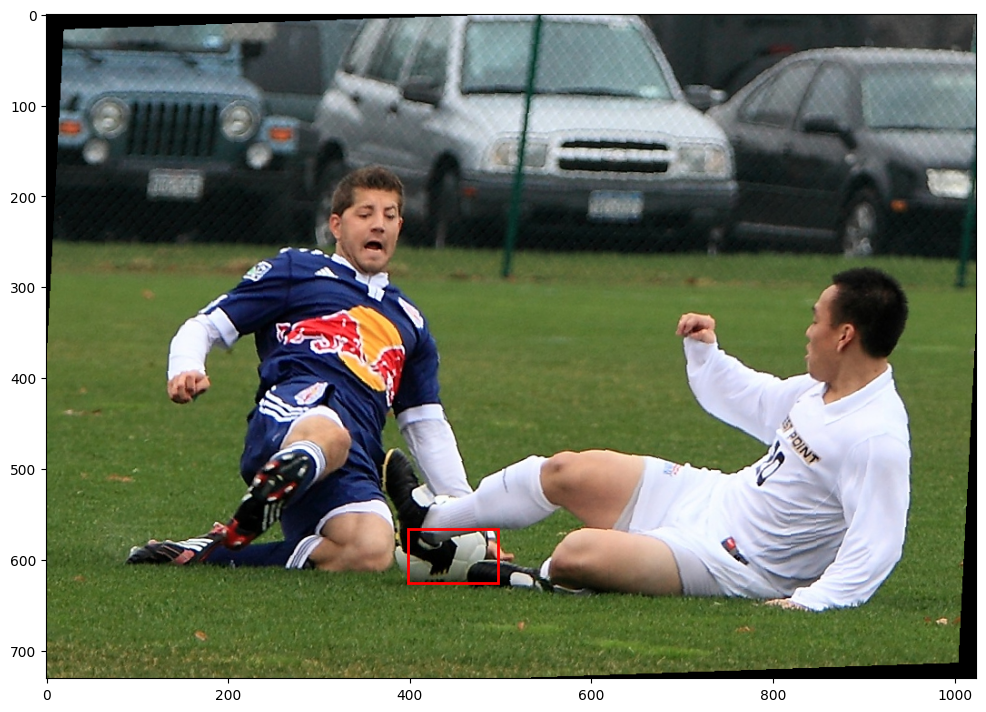

In [55]:
for images, targets in train_dataloader:

    image = images[0]
    target = targets[0]

    # Преобразуем тензор обратно в изображение для отображения
    image = image.permute(1, 2, 0).numpy()  # Изменяем размерность с (C, H, W) на (H, W, C)

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for bbox in target['boxes']:
        x_min, y_min, x_max, y_max = bbox.numpy()

        rect = patches.Rectangle((x_min * image.shape[1], y_min * image.shape[0]),
                                 (x_max - x_min) * image.shape[1],
                                 (y_max - y_min) * image.shape[0],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

    break

Потребовалась функция конвертации нормализованных box в пиксели для работы с Faster R-CNN

In [68]:
# Гарантируем xmin<xmax,ymin<ymax. Возвращаем тот же список по длине.
def targets_to_pixels(images, targets, min_side: float = 1.0):
    fixed = []
    for img, t in zip(images, targets):
        _, H, W = img.shape
        boxes = t["boxes"].clone()

        if boxes.numel() > 0:
            # Если выглядят как нормализованные — переводим
            if boxes.max() <= 1.0 + 1e-6:
                boxes[:, [0, 2]] *= W  # x
                boxes[:, [1, 3]] *= H  # y

            # clamp в границы изображения
            boxes[:, 0] = boxes[:, 0].clamp(0, W - 1)
            boxes[:, 2] = boxes[:, 2].clamp(0, W - 1)
            boxes[:, 1] = boxes[:, 1].clamp(0, H - 1)
            boxes[:, 3] = boxes[:, 3].clamp(0, H - 1)

            # гарантируем порядок
            x1 = torch.minimum(boxes[:, 0], boxes[:, 2])
            x2 = torch.maximum(boxes[:, 0], boxes[:, 2])
            y1 = torch.minimum(boxes[:, 1], boxes[:, 3])
            y2 = torch.maximum(boxes[:, 1], boxes[:, 3])
            boxes = torch.stack([x1, y1, x2, y2], dim=1)

            # фильтруем слишком маленькие боксы
            keep = ((boxes[:, 2] - boxes[:, 0]) >= min_side) & ((boxes[:, 3] - boxes[:, 1]) >= min_side)
            boxes = boxes[keep]
            labels = t["labels"][keep] if "labels" in t else torch.ones((len(boxes),), dtype=torch.int64)
        else:
            labels = t.get("labels", torch.empty((0,), dtype=torch.int64))

        fixed.append({
            "boxes": boxes.to(torch.float32).to(img.device),
            "labels": labels.to(torch.int64).to(img.device),
        })
    return fixed

### 2. Обучение

#### Подготовка модели

In [70]:
import torch.optim as optim

Заморозим все слои предобученной модели, чтобы их веса не изменялись

In [71]:
for param in model.parameters():
    param.requires_grad = False

# Размораживаем слои, которые требуется обучить – классификация

# извлекаем число входных признаков для последнего слоя классификатора в модели
in_features = model.roi_heads.box_predictor.cls_score.in_features

# заменяем текущий классификатор на новый, те же входные признаки, но 2 класса
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)  # 2 класса (мяч и фоновый класс)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

Оптимизатор: Adam

In [72]:
params = [param for param in model.parameters() if param.requires_grad]

optimizer = optimizer = optim.Adam(params, lr=0.0001)

In [78]:
import time

def train_model(model, dataloader, optimizer, num_epochs=5, log_every=10):
    model.train()
    epoch_losses = []
    for epoch in range(1, num_epochs + 1):
        run_loss, n = 0.0, 0
        for bi, (images, targets) in enumerate(dataloader):
            if len(images) == 0:
                continue

            images = [img.to(device) for img in images]

            # конвертируем таргеты в пиксели с учётом финального H,W
            pixel_targets = targets_to_pixels(images, targets)

            optimizer.zero_grad()
            loss_dict = model(images, pixel_targets)
            loss = sum(loss_dict.values())
            loss.backward()
            optimizer.step()

            run_loss += float(loss.item()); n += 1
            if bi % log_every == 0:
                print(f"[epoch {epoch}] batch {bi}/{len(dataloader)} loss={loss.item():.4f}")
        avg = run_loss / max(1, n)
        print(f"[epoch {epoch}] avg loss={avg:.4f}")
        epoch_losses.append(avg)
    return epoch_losses

train_model(model, train_dataloader, optimizer, num_epochs=10)

[epoch 1] batch 0/719 loss=0.8031
[epoch 1] batch 10/719 loss=0.7621
[epoch 1] batch 20/719 loss=0.8132
[epoch 1] batch 30/719 loss=0.7536
[epoch 1] batch 40/719 loss=1.0388
[epoch 1] batch 50/719 loss=0.8207
[epoch 1] batch 60/719 loss=0.8215
[epoch 1] batch 70/719 loss=0.8498
[epoch 1] batch 80/719 loss=1.0382
[epoch 1] batch 90/719 loss=0.7448
[epoch 1] batch 100/719 loss=0.7578
[epoch 1] batch 110/719 loss=0.8301
[epoch 1] batch 120/719 loss=0.7333
[epoch 1] batch 130/719 loss=0.8805
[epoch 1] batch 140/719 loss=0.8131
[epoch 1] batch 150/719 loss=0.7606
[epoch 1] batch 160/719 loss=0.7949
[epoch 1] batch 170/719 loss=0.8768
[epoch 1] batch 180/719 loss=0.7948
[epoch 1] batch 190/719 loss=0.7705
[epoch 1] batch 200/719 loss=0.8052
[epoch 1] batch 210/719 loss=0.8205
[epoch 1] batch 220/719 loss=0.7599
[epoch 1] batch 230/719 loss=0.7701
[epoch 1] batch 240/719 loss=0.7704
[epoch 1] batch 250/719 loss=0.7567
[epoch 1] batch 260/719 loss=1.0078
[epoch 1] batch 270/719 loss=1.1447
[ep

[0.8235031556187816,
 0.820893740620832,
 0.8176963123724755,
 0.8128535336347217,
 0.809619220224972,
 0.8061758237521738,
 0.8038151933188564,
 0.8023176878815068,
 0.8006944449123653,
 0.7998877103040215]

Предсказанные bounding boxes: [[374.65976   284.55518   486.885     398.48227  ]
 [  4.794399  544.42206   133.58424   629.75494  ]
 [  3.0204077 518.1397    136.35341   598.57434  ]
 [372.021     328.8643    497.8136    417.9939   ]
 [400.1275    314.82446   426.46826   340.76028  ]
 [423.53613   314.99335   450.21252   341.5169   ]
 [394.09976   285.43808   519.8846    363.38477  ]
 [ 19.830496  571.1407    167.08217   656.96173  ]
 [308.3892    272.20685   417.28723   376.40057  ]
 [203.65201   501.05276   278.48026   664.6792   ]
 [ 18.020662  444.76645    91.01701   611.9997   ]
 [131.3563    595.0609    244.1918    680.42395  ]
 [402.0572    301.76944   458.1778    355.875    ]
 [153.38486   561.00006   299.0664    644.642    ]
 [443.34607   296.17545   470.35233   323.69064  ]
 [  4.1122875 521.2396     60.235836  577.0059   ]
 [ 47.600056  537.41864    75.3305    564.84705  ]
 [429.88123   297.69128   457.0837    323.90277  ]
 [430.32495   320.998     456.60852   347.95905  ]
 

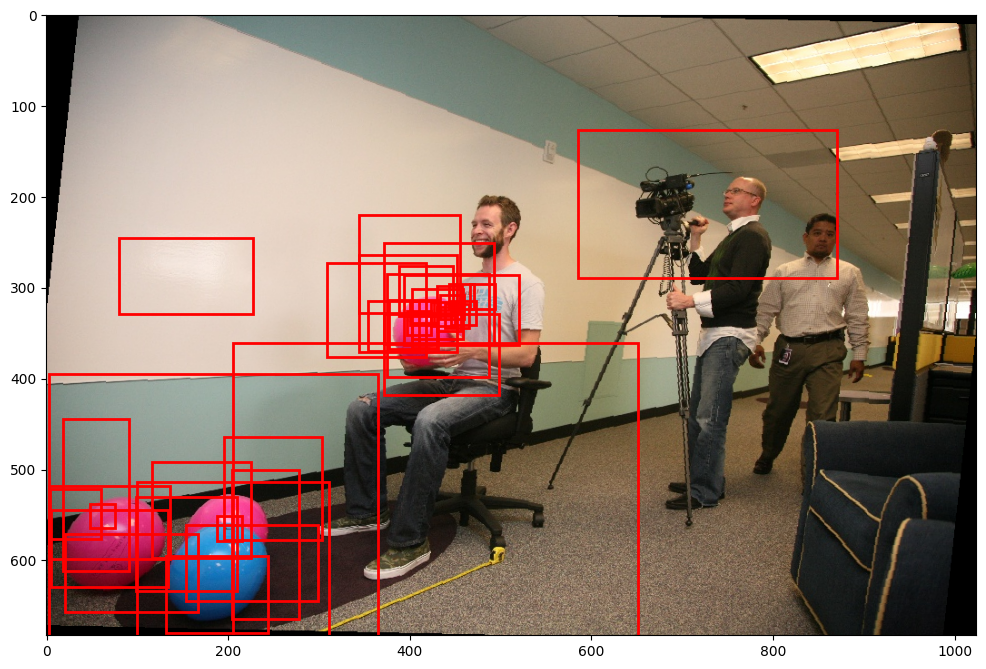

In [104]:
# Функция для отображения детекции с проверками
def display_detection_results(model, dataloader):
    model.eval()  # Переводим модель в режим инференса
    images, targets = next(iter(dataloader))  # Берем первый батч
    image = images[0].to(device)
    target = targets[0]

    with torch.no_grad():
        prediction = model([image])

    # Получаем предсказанные bounding boxes
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Проверяем форму предсказанных bounding boxes
    print(f"Предсказанные bounding boxes: {boxes}")
    print(f"Предсказанные метки: {labels}")
    print(f"Форма bounding boxes: {boxes.shape}")

    # Переводим изображение в формат (H, W, C)
    image = image.permute(1, 2, 0).cpu().numpy()


    print(f"Размер изображения: {image.shape}")


    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    # Отображаем предсказанные bounding boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        print(f"Рисуем bounding box: {x_min}, {y_min}, {x_max}, {y_max}")

        # Проверка, что bounding box в пределах изображения
        if x_min < 0 or y_min < 0 or x_max > 1 or y_max > 1:
            print("Ошибка: координаты bounding box выходят за пределы изображения!")

        rect = patches.Rectangle((x_min, y_min),
                                 (x_max - x_min),
                                 (y_max - y_min),
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Отображаем результаты после обучения
display_detection_results(model, train_dataloader)

### Выводы

Было много попыток, но в ограниченные сроки полностью выполнить все пункты задания не удалось.

В качестве вывода я хотел бы рассмотреть основные ошибки и трудности через, которые пришлось пройти, чтобы в дальнейшем их не совершать.


1. Проблемы с нормализацией bounding boxes

- Ошибка: В данных аннотаций для каждого объекта, координаты bounding boxes были нормализованы (в диапазоне от 0 до 1). Однако модель Faster R-CNN ожидает координаты в пикселях. Это привело к тому, что модель не могла корректно обучаться и делать предсказания.

- Вывод: Для корректной работы модели необходимо предварительно изучить, какой набор данных она принимает, также что bounding boxes в таргетах находятся в нужном масштабе – в случае детекции объектов для моделей типа Faster R-CNN, это должны быть пиксельные значения, а не нормализованные координаты.

2. Трансформации и аугментации

- Ошибка: Мы столкнулись с проблемой, что некоторые аугментации, такие как повороты и сдвиги, не учитывали изменения в bounding boxes, что могло привести к нарушению целостности данных.

- Вывод: Важно использовать такие библиотеки для аугментаций, как Albumentations, которые поддерживают работу с bounding boxes и автоматически пересчитывают их при применении геометрических преобразований. (Применение transform было плохой идеей).

3. Проблемы с гиперпараметрами

- Ошибка: Потери на первых эпохах обучения не падали так быстро, как ожидалось, что вызвало сомнения в правильности настроек модели и гиперпараметров.

- Вывод: Это может быть связано с несколькими
факторами: выбором скорости обучения, изначальной инициализацией модели, а также количеством и качеством данных. Возможно, для задачи детекции объектов требуется более низкий learning rate, чтобы избежать переобучения на первых эпохах.

4. Недостаточно эффективный и гибкий DataLoader

- Ошибка: В DataLoader были использованы жесткие фильтрации и преобразования данных (например, аугментации и преобразования размера изображений), которые не всегда учитывают изменения в bounding box.
- Вывод: использовать Albumentations.

5. Отсутствие проверки на пустые батчи

- Ошибка: Если в процессе обучения попадались пустые батчи (например, из-за фильтрации пустых боксов), они могли привести к сбоям или к невозможности корректно тренировать модель.

- Вывод: добавить фильтрацию пустых данных, чтобы избежать ошибок при обучении

6. Мало логирования и отладки

- Ошибка: недостаточно тщательно логировали процесс, особенно на начальных этапах. Когда не было предсказаний, было сложно понять, на каком шаге произошла ошибка.

- Вывод: Необходимо добавить больше логирования и проверок на каждом этапе.


 Таким образом, было выявлено несколько ключевых ошибок в подготовке данных и трансформациях, которые значительно влияют на эффективность работы модели. В будущем важно уделить внимание более тщательной настройке гиперпараметров и использованию соответствующих методов для работы с данными, чтобы ускорить и улучшить процесс обучения.